# **Project: Time Series - Forecasting Stock Prices**
# Marks: 30

Welcome to the project on Time Series. We will use the Amazon Stock Prices dataset for this project.
 
----------------
## **Context:** 
----------------

**Stocks are one of the most popular financial instruments invented for building wealth** and are the **centerpiece of any investment portfolio.** Recent advances in trading technology have opened up stock markets in such a way that nowadays, **nearly anybody can own stock.** 

In the last few decades, there's been an **explosive increase in the average person's interest for the stock market.** This makes stock value prediction an interesting and popular problem to explore.


------------------
## **Objective:**
------------------

Amazon.com, Inc. engages in the retail sale of consumer products and subscriptions in North America as well as internationally. This dataset consists of monthly average stock closing prices of Amazon over a period of 12 years from 2006 to 2017. We have to **build a time series model** using the AR, MA, ARMA and ARIMA models in order to **forecast the stock closing price of Amazon.**

--------------------------
## **Data Dictionary:**
--------------------------
- **date:** Date when the price was collected
- **close:** Closing price of the stock

### Importing libraries

In [48]:
# Install this to upgrade the statsmodels package. It will be required to use AR, MA, & ARMA models
!pip install statsmodels --upgrade

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [49]:
#If the above command doesn't work, please run the below command in the anaconda prompt, otherwise ignore
#conda install statsmodels

In [50]:
# Importing libraries for data manipulation
import pandas as pd
import numpy as np

#Importing libraries for visualization
import matplotlib.pylab as plt
import seaborn as sns

#Importing library for date manipulation
from datetime import datetime

#To calculate the MSE or RMSE
from sklearn.metrics import mean_squared_error

#Importing acf and pacf functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Importing models from statsmodels library
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

#To ignore the warnings
import warnings
warnings.filterwarnings('ignore')

### Reading the dataset

In [51]:
#If you are having an issue while loading the excel file in pandas, please run the below command in anaconda prompt, otherwise ignore.
#conda install -c anaconda xlrd

In [52]:
df = pd.read_excel('amazon_stocks_prices.xlsx')
df.head()

,date,close
0,2006-01-01,45.22
1,2006-02-01,38.82
2,2006-03-01,36.38
3,2006-04-01,36.32
4,2006-05-01,34.13


### Checking info 

### **Question 1: Check the info of the dataset and write your observations. (2 Marks)**

In [53]:
#Write your code here
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    144 non-null    datetime64[ns]
 1   close   144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


None

**Observations:_____________**
- The timeserie has 144 observations with no missing values
- The variable data is in date-time format. The variable close is numerical. 

In [54]:
# Setting date as the index
df = df.set_index(['date'])
df.head()

,close
date,
2006-01-01,45.22
2006-02-01,38.82
2006-03-01,36.38
2006-04-01,36.32
2006-05-01,34.13


Now, let's **visualize the time series** to get an idea about the trend and/or seasonality within the data.

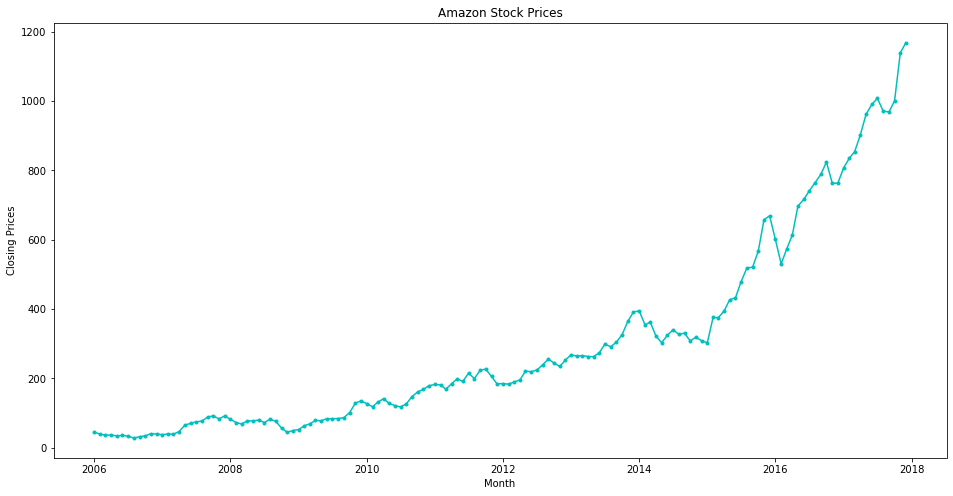

In [55]:
# Visualizing the time series
plt.figure(figsize=(16,8))
plt.xlabel("Month")
plt.ylabel("Closing Prices")
plt.title('Amazon Stock Prices')
plt.plot(df.index, df.close, color = 'c', marker='.')

**Observations:**
- We can see that the series has an **upward trend with some seasonality.** This implies that the **average stock price of Amazon has been increasing almost every year.**
- Before building different models, it is important to **check whether the series is stationary or not.**

Let us first split the dataset into train and test data

### Splitting the dataset

In [56]:
# Splitting the data into train and test
df_train = df.loc['2006-01-01':'2015-12-01']
df_test = df.loc['2016-01-01' : '2017-12-01']
print(df_train)
print(df_test)

             close
date              
2006-01-01   45.22
2006-02-01   38.82
2006-03-01   36.38
2006-04-01   36.32
2006-05-01   34.13
...            ...
2015-08-01  518.46
2015-09-01  520.96
2015-10-01  566.74
2015-11-01  657.70
2015-12-01  669.26

[120 rows x 1 columns]
              close
date               
2016-01-01   601.06
2016-02-01   530.62
2016-03-01   572.37
2016-04-01   613.59
2016-05-01   697.47
2016-06-01   716.39
2016-07-01   741.47
2016-08-01   764.84
2016-09-01   788.97
2016-10-01   824.44
2016-11-01   763.34
2016-12-01   763.33
2017-01-01   807.51
2017-02-01   835.75
2017-03-01   854.24
2017-04-01   903.39
2017-05-01   961.72
2017-06-01   990.44
2017-07-01  1008.48
2017-08-01   971.44
2017-09-01   968.99
2017-10-01  1000.72
2017-11-01  1139.81
2017-12-01  1168.84


Now let us check the **rolling mean and standard deviation** of the series to **visualize if the series has any trend or seasonality.**

### Testing the stationarity of the series

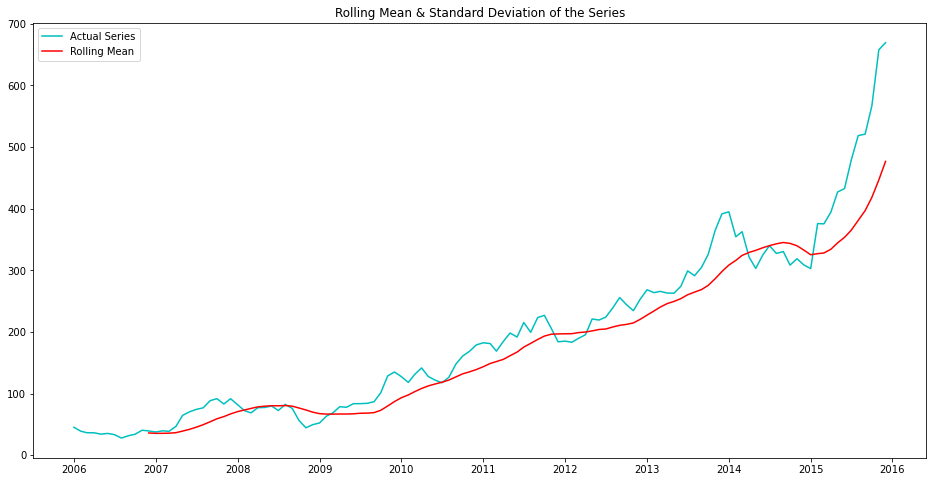

In [57]:
# Calculating the rolling mean and standard deviation for a window of 12 observations
rolmean=df_train.rolling(window=12).mean()
rolstd=df_train.rolling(window=12).std()

#Visualizing the rolling mean and standard deviation

plt.figure(figsize=(16,8))
actual = plt.plot(df_train, color='c', label='Actual Series')
rollingmean = plt.plot(rolmean, color='red', label='Rolling Mean') 
#rollingstd = plt.plot(rolstd, color='green', label='Rolling Std. Dev.')
plt.title('Rolling Mean & Standard Deviation of the Series')
plt.legend()
plt.show()

**Observations:**
- We can see there is an upward trend in the series.
- We can confirm that **the series is not stationary.**

We can also use the **Augmented Dickey-Fuller (ADF) Test** to verify if the series is stationary or not.
The null and alternate hypotheses for the ADF Test are defined as: 
- **Null hypothesis:** The Time Series is non-stationary
- **Alternative hypothesis:** The Time Series is stationary

In [58]:
#Define a function to use adfuller test
def adfuller(df_train):
  #Importing adfuller using statsmodels
  from statsmodels.tsa.stattools import adfuller
  print('Dickey-Fuller Test: ')
  adftest = adfuller(df_train['close'])
  adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations'])
  for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
  print(adfoutput)
adfuller(df_train)

Dickey-Fuller Test: 
Test Statistic            3.464016
p-value                   1.000000
Lags Used                 0.000000
No. of Observations     119.000000
Critical Value (1%)      -3.486535
Critical Value (5%)      -2.886151
Critical Value (10%)     -2.579896
dtype: float64


**Observations:**
1. From the above test, we can see that the **p-value = 1 i.e. > 0.05** (For 95% confidence intervals) therefore, **we fail to reject the null hypothesis.**
2. Hence, **we can confirm that the series is non-stationary.**

### Making the series stationary

We can use some of the following methods to convert a non-stationary series into a stationary one:
1. **Log Transformation**
2. **By differencing the series (lagged series)**

Let's first use a log transformation over this series to remove exponential variance and check the stationarity of the series again.

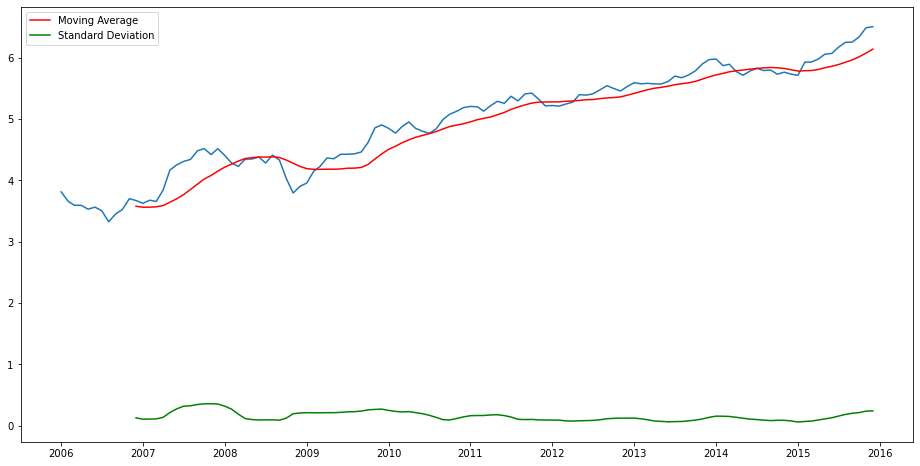

In [59]:
# Visualize the rolling mean and standard deviation after using log transformation
plt.figure(figsize=(16,8))
df_log = np.log(df_train)
MAvg = df_log.rolling(window=12).mean()
MStd = df_log.rolling(window=12).std()
plt.plot(df_log)
plt.plot(MAvg, color='r', label = 'Moving Average')
plt.plot(MStd, color='g', label = 'Standard Deviation')
plt.legend()
plt.show()

**Observations:**
- Since **we can still see the upward trend in the series**, we can conclude that **the series is still non-stationary.** 
- However, the standard deviation is almost constant which implies that **now the series has constant variance.**

**Let's shift the series by order 1 (or by 1 month) & apply differencing (using lagged series)** and then check the rolling mean and standard deviation.

### **Question 2: Visualize the rolling mean and rolling standard deviation of the shifted series (df_shift) and check the stationarity by calling the adfuller() function. Also, write your observations on the same. (3 Marks)**

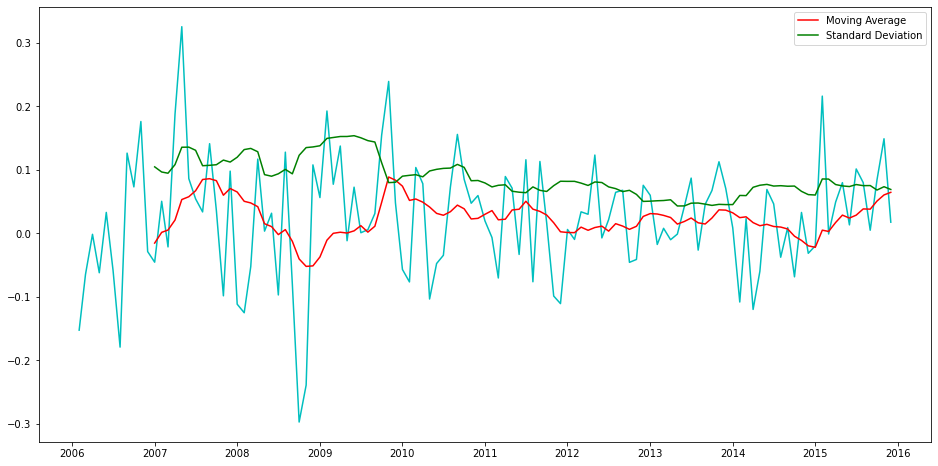

In [60]:
plt.figure(figsize=(16,8))
df_shift = df_log - df_log.shift(periods = 1)
MAvg_shift =  df_shift.rolling(window=12).mean()
MStd_shift = df_shift.rolling(window=12).std()
plt.plot(df_shift, color='c')
plt.plot(MAvg_shift, color='red', label = 'Moving Average')
plt.plot(MStd_shift, color='green', label = 'Standard Deviation')
plt.legend()
plt.show()

#Dropping the null values that we get after applying differencing method
df_shift = df_shift.dropna()

**Observations:___________________** 
- We have computed the time-derivative of log(x) where x was the original closing price (we can write this as xnew=d log(x)/dt. We havent dimensionalized by time, so the unit is still in dollars instead of dollars per months). From now on we will work with this new variable. 
- The running mean and running std for the new variable look stationnary (near constant). Let us use the adfuller test to check the stationarity.

In [61]:
adfuller(df_shift) # call the adfuller function for df_shift series

Dickey-Fuller Test: 
Test Statistic         -8.640344e+00
p-value                 5.447548e-14
Lags Used               0.000000e+00
No. of Observations     1.180000e+02
Critical Value (1%)    -3.487022e+00
Critical Value (5%)    -2.886363e+00
Critical Value (10%)   -2.580009e+00
dtype: float64


**Observations:**
- The p-value for the Dickey-Fuller Test is -5 10^-14, p<0.05 therefore we accept the null hypothesis that the timeserie is stationary.

Let's decompose the time series to check its different components.

### Decomposing the time series components into Trend, Seasonality and Residual

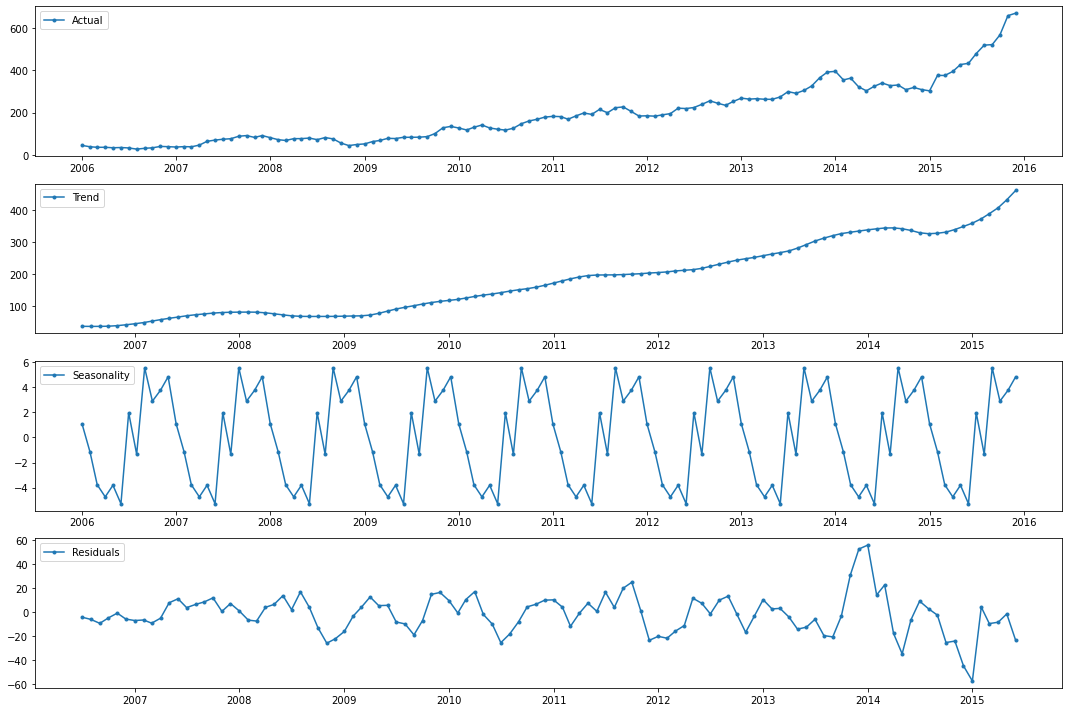

In [62]:
#Importing the seasonal_decompose function to decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df_train)

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(df_train, label='Actual', marker='.')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', marker='.')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', marker='.')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', marker='.')
plt.legend(loc='upper left')
plt.tight_layout()

**Observations:**
- We can see that there are significant **trend, seasonality and residuals components** in the series
- The plot for seasonality shows that **Amazon's stock prices spike in July, September, and December.**

**Now let's move on to the model building section. First, we will plot the `ACF` and `PACF` plots to get the values of p and q i.e. order of AR and MA models to be used.**

### Plotting the auto-correlation function and partial auto-correlation function to get p and q values for AR, MA, ARMA, and ARIMA models

<Figure size 1152x576 with 0 Axes>

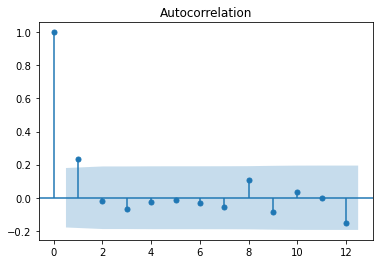

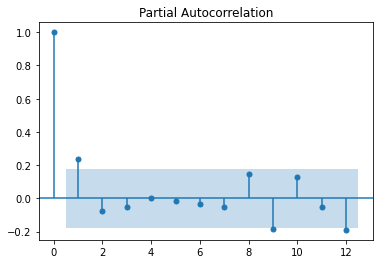

In [63]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plt.figure(figsize = (16,8))
plot_acf(df_shift, lags = 12) 
plt.show() 
plot_pacf(df_shift, lags = 12) 
plt.show()

**Observations:**
- From the above PACF plot we can see that **the highest lag** at which the plot extends beyond the statistically significant boundary is **lag 1.** 
- This indicates that an **AR Model of lag 1 (p=1)** should be sufficient to fit the data.
- Similarly, from the ACF plot, we can infer that **q=1.**

### AR Model

### **Question 3: Fit and predict the shifted series with the AR Model and calculate the RMSE. Also, visualize the time series and write your observations. (5 Marks)**

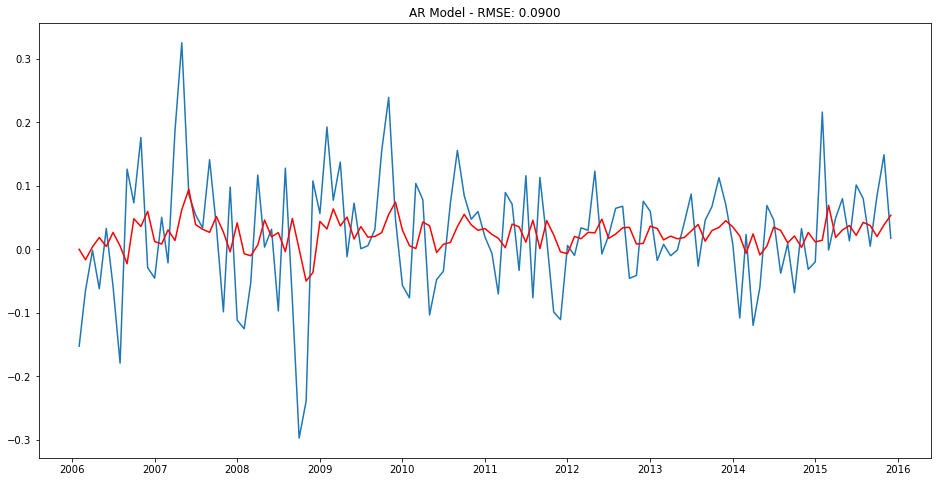

In [64]:
#Importing AutoReg function to apply AR model
from statsmodels.tsa.ar_model import AutoReg

plt.figure(figsize=(16,8))
model_AR = AutoReg(df_shift, lags=1) #Use number of lags as 1 and apply AutoReg function on df_shift series
results_AR = model_AR.fit() #fit the model
plt.plot(df_shift)
predict = results_AR.predict(start=0,end=len(df_shift)-1) #predict the series 
predict = predict.fillna(0) #Converting NaN values to 0
plt.plot(predict, color='red')
plt.title('AR Model - RMSE: %.4f'% mean_squared_error(predict,df_shift['close'], squared=False))  #Calculating rmse
plt.show()

**Observations:________________________**
- The AR model does a poor job at predicting the timeserie on the train dataset (its amplitude is too weak).
- We should not have chosen an AR Model in the first place, because the ACF and PACF plots were inconclusive. In order to choose an AR model, the ACF should decay exponentially with lag while the PACF should clearly cutoff. For inconclusive plots we should choose the ARIMA model instead. 

**Let's check the AIC value** of the model

In [65]:
results_AR.aic

-4.781419615400342

Now, let's build MA, ARMA, and ARIMA models as well, and see if we can get a better model 

### MA Model

**We will be using an ARIMA model with p=0 and d=0 so that it will work as an MA model**

### **Question 4: Fit and predict the shifted series with the MA Model and calculate the RMSE. Also, visualize the time series and write your observations. (2 Marks)**

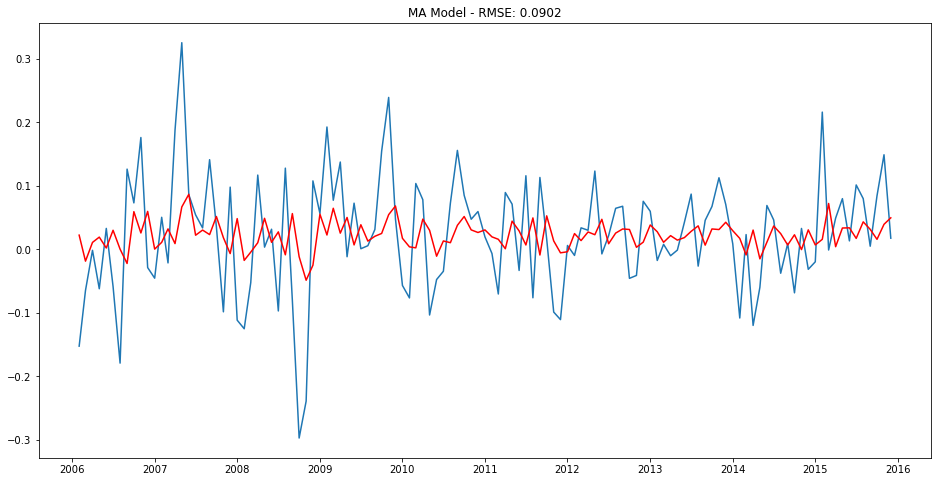

In [66]:
from statsmodels.tsa.arima_model import ARIMA
plt.figure(figsize=(16,8))
model_MA = ARIMA(df_shift, order=(0, 0, 1)) #Using p=0, d=0, q=1 and apply ARIMA function on df_shift series
results_MA = model_MA.fit() #fit the model
plt.plot(df_shift)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('MA Model - RMSE: %.4f'% mean_squared_error(results_MA.fittedvalues,df_shift['close'], squared=False))
plt.show()

**Observations:________________________**
- Similar to the AR model, the AM model does a poor job at predicting the timeserie on the train dataset (its variations are too weak, although it is possible that the values match if applying a rolling mean). We should not have chosen AR nor AM model but ARMA based on the ACF and PACF plots (see discussion above).

Let's check the AIC value of the model

In [67]:
results_MA.aic

-229.09493930954125

- **The MA model is giving a much lower AIC** when compared to the AR model, implying that **the MA model fits the training data better.** 

### ARMA Model

We will be using an **ARIMA model with p=1 and q=1** (as observed from the ACF and PACF plots) **and d=0 so that it will work as an ARMA model.**

### **Question 5: Fit and predict the shifted series with the ARMA Model and calculate the RMSE. Also, visualize the time series and write your observations. (2 Marks)**

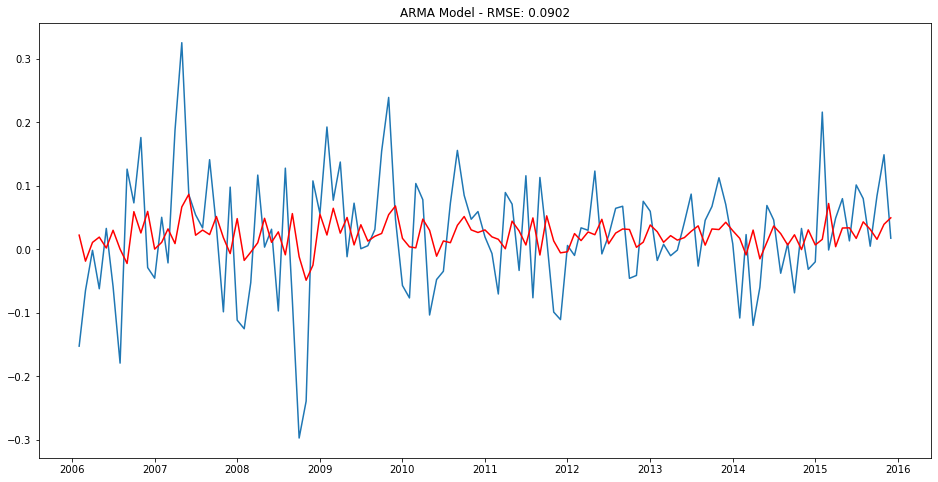

In [68]:
plt.figure(figsize=(16,8))
model_ARMA = ARIMA(df_shift, order=(1, 0, 1)) #Using p=1, d=0, q=1 and apply ARIMA function on df_shift series
results_ARMA = model_MA.fit() #fit the model
plt.plot(df_shift)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('ARMA Model - RMSE: %.4f'% mean_squared_error(results_ARMA.fittedvalues,df_shift['close'], squared=False))
plt.show()

**Observations:**
- The ARMA model (with the present parameters p=1,q=1) has the same issues as the AR and MA models (its variations are too weak, although it is possible that the values match if applying a rolling mean).
- For an ARMA model, we shouldnt have chosen p and q from the ACF and PACF plots (because the theory doesnt hold). It is very likely that p=1 and q=1 here are too low (implying weak system memory). For an ARMA model we need to determine p and q rather through hyperparameter search (with AIC as a metric scorer). 

**Let's check the AIC value** of the model

In [69]:
results_ARMA.aic

-229.09493930954125

- **The AIC value of the ARMA model is more or less similar** to MA model 

**Let us try using the ARIMA Model.**

### ARIMA Model

We will be using an **ARIMA Model with p=1, d=1, & q=1**.

### **Question 6: Fit and predict the shifted series with the ARIMA Model and calculate the RMSE. Also, visualize the time series and write your observations. (2 Marks)**

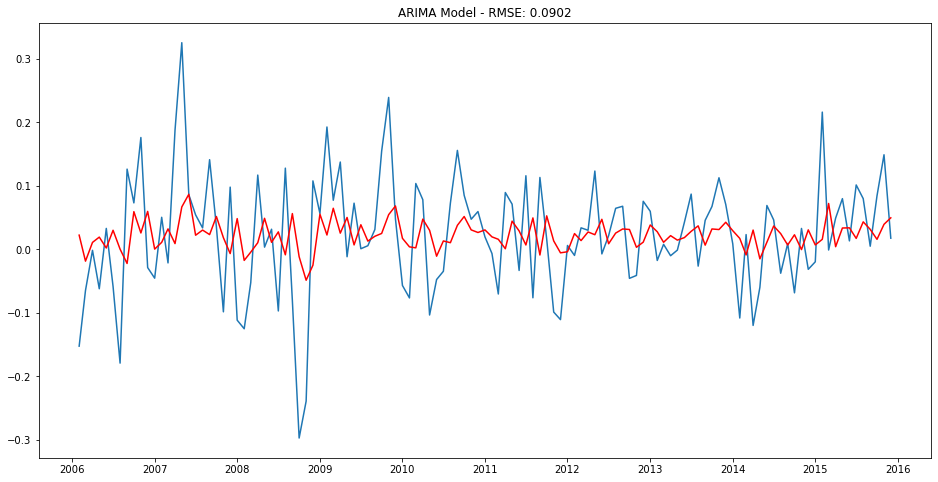

In [70]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize=(16,8))
model_ARIMA = ARIMA(df_shift, order=(1, 1, 1)) #Using p=1, d=1, q=1 and apply ARIMA function on df_log series
results_ARIMA = model_MA.fit() #fit the model
plt.plot(df_shift)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('ARIMA Model - RMSE: %.4f'% mean_squared_error(results_ARIMA.fittedvalues,df_shift['close'], squared=False))
plt.show()

**Observations:________**
- The ARIMA model (with the present parameters p=1,q=1) has the same issues as the AR, MA and ARMA models (its variations are too weak, although it is possible that the values match if applying a rolling mean).
- We should chose p,q as well as d from an hyperparameter search with AIC as metric scorer (see discussion above). This would likely result in much improved model performances. 
- If using ARIMA, it would have made more sense to use the transformed variable Xnew=log(X) instead of the present transformed variable Xnew=dlog(X) / dt, where X is the original variable of closing price. When doing ARIMA the search for time derivatives of order d is implicit.

**Let's check the AIC value** of the model

In [71]:
results_ARIMA.aic

-229.09493930954125

- **The AIC value of the ARIMA model is the same** as the ARMA model. 

We can see that **all the models return almost the same RMSE.** There is not much difference in AIC value as well across all the models except for the AR model.

**We can choose to predict the values using ARIMA as it takes into account more factors than AR, MA, ARMA models.**

In [72]:
# Printing the fitted values
predictions=pd.Series(results_ARIMA.fittedvalues)
predictions

date
2006-02-01    0.022256
2006-03-01   -0.018705
2006-04-01    0.010803
2006-05-01    0.019159
2006-06-01    0.002021
                ...   
2015-08-01    0.043187
2015-09-01    0.031356
2015-10-01    0.015653
2015-11-01    0.039314
2015-12-01    0.049503
Length: 119, dtype: float64

### Inverse Transformation

Now we have fitted values using the ARIMA model, **we will use the inverse transformation to get back the original values.**

### **Question 7: Apply an inverse transformation on the predictions of the ARIMA Model. (5 Marks)**

In [73]:
#First step - doing cumulative sum
predictions_cumsum = predictions.cumsum() # use .cumsum fuction on the predictions
predictions_cumsum

date
2006-02-01    0.022256
2006-03-01    0.003552
2006-04-01    0.014354
2006-05-01    0.033514
2006-06-01    0.035535
                ...   
2015-08-01    2.530335
2015-09-01    2.561691
2015-10-01    2.577344
2015-11-01    2.616658
2015-12-01    2.666161
Length: 119, dtype: float64

In [74]:
#Second step - Adding the first value of the log series to the cumulative sum values
predictions_log = pd.Series(df_log['close'].iloc[0], index=df_log.index)
predictions_log = predictions_log.add(predictions_cumsum, fill_value=0)
predictions_log

date
2006-01-01    3.811539
2006-02-01    3.833796
2006-03-01    3.815091
2006-04-01    3.825894
2006-05-01    3.845053
                ...   
2015-08-01    6.341874
2015-09-01    6.373230
2015-10-01    6.388883
2015-11-01    6.428198
2015-12-01    6.477700
Length: 120, dtype: float64

In [75]:
#Third step - applying exponential transformation
predictions_ARIMA = np.exp(predictions_log) #use exponential function
predictions_ARIMA

date
2006-01-01     45.220000
2006-02-01     46.237722
2006-03-01     45.380885
2006-04-01     45.873785
2006-05-01     46.761174
                 ...    
2015-08-01    567.859576
2015-09-01    585.947459
2015-10-01    595.191669
2015-11-01    619.057118
2015-12-01    650.473339
Length: 120, dtype: float64

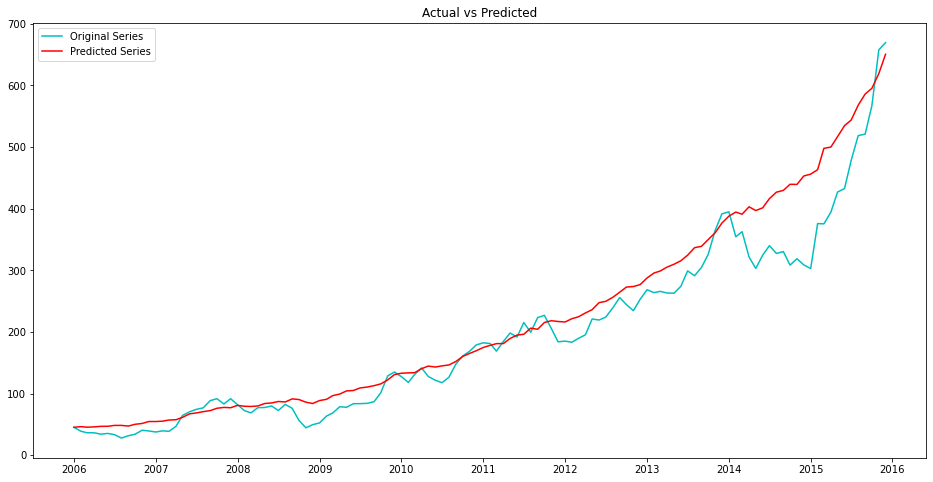

In [76]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(df_train, color = 'c', label = 'Original Series')  #plot the original train series
plt.plot(predictions_ARIMA, color = 'r', label = 'Predicted Series')  #plot the predictions_ARIMA 
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**Observations:**
- We can see that **the predicted series is very similar to the original series** i.e. The model is good at predicting values on the training data except for the dip in stock prices in 2015 which may have been due to some external factors that are not included in this model. 
- Let us **forecast the closing prices for the next 24 months.**

### Forecasting the values for next 24 months and compare it with test data

**To forecast the values for the next 24 months using the ARIMA model, we need to follow the steps below:**
1. Forecast the log-transformed fitted values for the next 24 months
2. Make a list of these 24 month (2016-2017) forecasted values
3. Convert that list into a series so that we can work with pandas functions 
4. Make a dataframe where we have the dates starting from 2016-01-01 to 2017-12-01 as the index and the respective forecasted values
5. Apply the inverse transformation and get the real forecasted values

### **Question 8: Forecast the stocks prices for the next 24 months and perform the inverse transformation. (5 Marks)**

In [77]:
#Forecasting the values for next 24 months
forecasted_ARIMA = results_ARIMA.forecast(steps=24) #forecast using the results_ARIMA for next 24 months. Keep steps=24
forecasted_ARIMA[0]

array([0.01427693, 0.02225649, 0.02225649, 0.02225649, 0.02225649,
       0.02225649, 0.02225649, 0.02225649, 0.02225649, 0.02225649,
       0.02225649, 0.02225649, 0.02225649, 0.02225649, 0.02225649,
       0.02225649, 0.02225649, 0.02225649, 0.02225649, 0.02225649,
       0.02225649, 0.02225649, 0.02225649, 0.02225649])

In [78]:
# Creating a list containing all the forecasted values
list1 = forecasted_ARIMA[0].tolist()
series1 = pd.Series(list1)
series1

0     0.014277
1     0.022256
2     0.022256
3     0.022256
4     0.022256
5     0.022256
6     0.022256
7     0.022256
8     0.022256
9     0.022256
10    0.022256
11    0.022256
12    0.022256
13    0.022256
14    0.022256
15    0.022256
16    0.022256
17    0.022256
18    0.022256
19    0.022256
20    0.022256
21    0.022256
22    0.022256
23    0.022256
dtype: float64

In [79]:
#Making a new dataframe to get the additional dates from 2016-2018
index = pd.date_range('2016-01-1','2018-1-1' , freq='1M')- pd.offsets.MonthBegin(1)
df1 = pd.DataFrame()
df1['forecasted'] = series1
df1.index = index
df1

,forecasted
2016-01-01,0.014277
2016-02-01,0.022256
2016-03-01,0.022256
2016-04-01,0.022256
2016-05-01,0.022256
2016-06-01,0.022256
2016-07-01,0.022256
2016-08-01,0.022256
2016-09-01,0.022256
2016-10-01,0.022256


In [85]:
#Applying exponential transformation to the forecasted log values

forecasted_ARIMA=df1['forecasted']
forecasted_ARIMA=forecasted_ARIMA.cumsum()# # WE MUST USE THE CUMSUM (integral) AS WELL
forecasted_ARIMA += float(predictions_log.loc['2015-12-01'])# AND ADD LAST VALUE FROM PREDICTION TRAINING DATA

forecasted_ARIMA = np.exp(forecasted_ARIMA) #use exponential function on forecasted data



forecasted_ARIMA

2016-01-01     659.826711
2016-02-01     674.676779
2016-03-01     689.861062
2016-04-01     705.387084
2016-05-01     721.262534
2016-06-01     737.495277
2016-07-01     754.093355
2016-08-01     771.064989
2016-09-01     788.418587
2016-10-01     806.162745
2016-11-01     824.306253
2016-12-01     842.858100
2017-01-01     861.827474
2017-02-01     881.223774
2017-03-01     901.056606
2017-04-01     921.335797
2017-05-01     942.071392
2017-06-01     963.273662
2017-07-01     984.953110
2017-08-01    1007.120477
2017-09-01    1029.786742
2017-10-01    1052.963135
2017-11-01    1076.661136
2017-12-01    1100.892484
Name: forecasted, dtype: float64

Now, let's try to visualize the original data with the predicted values on the training data and the forecasted values.

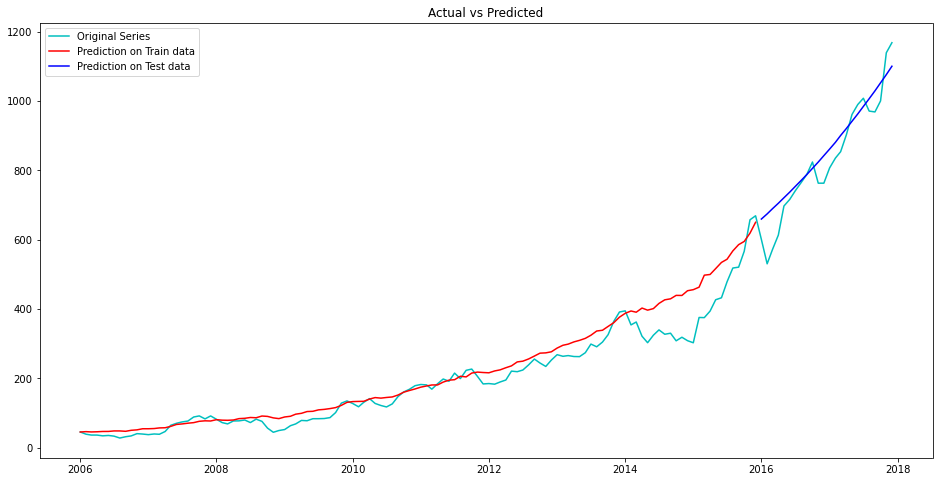

In [86]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(df, color = 'c', label = 'Original Series')
plt.plot(predictions_ARIMA, color = 'r', label = 'Prediction on Train data') #plot the predictions_ARIMA series
plt.plot(forecasted_ARIMA, label = 'Prediction on Test data', color='b')  #plot the forecasted_ARIMA series
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**Observations:**
- **As observed earlier, most of the predicted values on the training data are very close to the actual values** except for the dip in stock prices in the year 2015.
- **On the test data, the model is able to correctly predict the trend of the stock prices**, as we can see that the blue line appears to be close to the actual values (cyan blue) and they both have an upward trend. **However the test predictions are not able to identify the volatile variations in the stock prices over the last 2 years.**

Let's test the RMSE of the transformed predictions and the original value on the training and testing data to check whether the model is giving a generalized performance or not.

### **Question 9: Check the RMSE on the original train and test data and write your conclusion from the above analysis. (4 Marks)**

In [87]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(predictions_ARIMA, df_train, squared = False) #calculate RMSE using the predictions_ARIMA and df_train 
error

44.16599388023532

In [89]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(forecasted_ARIMA, df_test, squared = False)  #calculate RMSE using the forecasted_ARIMA and df_test
error

58.99694127131219

### Conclusion

**Write your conclusion here**

We have derived an ARIMA model for predicting trends in Amazon stock prices. The model was built using monthly data from 2006-215 and tested on 2016-2017 data. We also have tested AR, MA and ARMA models. 

**Model Building**

- The data had no missing values. Nevertheless, we applied feature transformations in order to render the timeserie stationary (log transformation then time derivative). The transformed timeserie's stationarity was verified (Dickey-Fuller test).
- We tested fitting AR, MA,ARMA and ARIMA models. The ARIMA model was selected based on having the best AIC metric. The hyperparameters (p,d,q) were chosen based on ACF and PACF (see discussion below). 

**Model Use**

The model is able to predict the broad trends in Amazon Stock prices with good accuracy (RMSE=58 dollars on test data). It is slightly overfitted (as seen on slightly increased RMSE on test data compared to train data) but still generalizable. This is a model that can be used in practice if its limitations are acknowledged. However, it performs poorly in predicting volatile (i.e. fast-varying) fluctuations in the stock price and shouldn't be used for that purpose. 


**Model Improvements**
- We were correct to discard the AR an AM models because the ACF and PACF plots were inconclusive. However, we still selected p and q based on these plots which is incorrect. For an ARIMA (or ARMA) model, these hyperparameters need to be selected through grid search with AIC as a metric scorer. It is very likely that p=1 and q=1 chosen here are too low (implying weak system memory), and that increased values may yield improved model performances.
- We build an ARIMA model with d=1 on the time derivative Xnew=dlog(X) /dt where X is original stock price. This doesnt make sense from a methodological point of view, it would have made more sense to equivalently test an ARIMA model with d=2 on the transformed variable Xnew=log(X). However, maybe the present method was used to first ensure stationary. Similar to p and q, the hyperparameter d should also be determined thourgh grid search with AIC as metric scorer (as well as systematic test for stationarity).
- From a business point of view, it is very likely that many external factors influence the Amazon stock price. An improved model should be multivariate, with additional timeseries related to the stock evolution (e.g. Amazon sales, sentiment analysis, etc). For a multivariate model we could consider the VAR (Vector Auto Regression) method, and its equivalent to ARIMA called VARIMAX.

